In [1]:
pip install simpy networkx qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 77.3 MB/s eta 0:00:00


In [2]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt
import builtins
from typing import List, Union
from qutip import *
import numpy as np

# Global Parameters and Definitions

In [3]:
# Optical Fiber Properties
L_att = 22e3       # attenuation length of optical fiber
c = 2e8            # speed of light in fiber optic


# Set Up
zero_ket = basis(2,0)
one_ket = basis(2,1)
zero_rho = zero_ket * zero_ket.dag()
one_rho = basis(2,1) * basis(2,1).dag()
I = lambda: qeye(2)
H = (sigmaz() + sigmax()) * np.sqrt(1/2)
CNOT = Qobj([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]], dims=[[2,2],[2,2]])
phi_plus_ket = (tensor(one_ket, one_ket) + tensor(zero_ket, zero_ket)).unit()
phi_plus_rho = phi_plus_ket * phi_plus_ket.dag()

# Error Model

In [13]:

def initial_rho(num_qubits: int):
    assert isinstance(num_qubits, int) and num_qubits > 0, "num_qubits must be a positive integer."
    zero_rho = basis(2, 0) * basis(2, 0).dag()  # Density matrix for the |0⟩ state
    return tensor([zero_rho for _ in range(num_qubits)])

def pad_op(op: Qobj, left_padding: int, right_padding: int, num_qubits: int):
    assert isinstance(op, Qobj), "op must be a Qobj."
    assert isinstance(left_padding, int) and left_padding >= 0, "left_padding must be a non-negative integer."
    assert isinstance(right_padding, int) and right_padding >= 0, "right_padding must be a non-negative integer."

    if left_padding > 0:
        left_op = tensor([I()] * left_padding)
        op = tensor(left_op, op)

    if right_padding > 0:
        right_op = tensor([I()] * right_padding)
        op = tensor(op, right_op)

    return op

def perfect_phi_plus_gen(rho: Qobj, num_qubits_left: int, num_qubits_right: int, num_qubits: int):
    H_op = pad_op(H, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    CNOT_op = pad_op(CNOT, left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)

    rho = H_op * rho * H_op.dag()
    rho = CNOT_op * rho * CNOT_op.dag()
    return rho


def dephasing_channel(rho: Qobj, t: float, T_dp: float, d: float, left_padding: int, right_padding: int, num_qubits: int):
    # convert time units to real life time units
    t = t * 2 * d / c
    dp_prob = (1 - np.exp(-t / T_dp)) / 2

    Z_op = np.sqrt(dp_prob) * pad_op(op=sigmaz(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    I_op = np.sqrt(1 - dp_prob) * pad_op(op=I(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    rho_t = I_op * rho * I_op.dag() + Z_op * rho * Z_op.dag()
    return rho_t


def entanglement_generation(communication, rho: Qobj, target_qubits: list, num_qubits: int, T_dp: float, d: float):
    start_time = time.time()

    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    # Step 1: Apply H gate
    H_start_time = time.time()
    rho = perfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, num_qubits)
    H_end_time = time.time()
    print(f"Time taken by H gate application: {round(H_end_time - H_start_time, 2)} seconds")

    # Step 2: Apply dephasing on q0
    dephase_start_time_q0 = time.time()
    rho = dephasing_channel(rho=rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    dephase_end_time_q0 = time.time()
    print(f"Time taken by dephasing on q0: {round(dephase_end_time_q0 - dephase_start_time_q0, 2)} seconds")

    # Step 3: Apply dephasing on q1
    dephase_start_time_q1 = time.time()
    rho = dephasing_channel(rho=rho, t=d / c, T_dp=T_dp, d=d, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)
    dephase_end_time_q1 = time.time()
    print(f"Time taken by dephasing on q1: {round(dephase_end_time_q1 - dephase_start_time_q1, 2)} seconds")

    end_time = time.time()
    print(f"Total time taken by entanglement_generation: {round(end_time - start_time, 2)} seconds")

    return rho



def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int):
    start_time = time.time()

    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    # Step 1: Bell measurement
    bell_measure_start_time = time.time()
    bell_measure_op = pad_op(phi_plus_rho, left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()
    bell_measure_end_time = time.time()
    print(f"Time taken by Bell measurement: {round(bell_measure_end_time - bell_measure_start_time, 2)} seconds")

    end_time = time.time()
    print(f"Total time taken by entanglement_swapping: {round(end_time - start_time, 2)} seconds")

    return rho



# Grid Network

In [16]:
import time

class CustomGrid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env
        self.network = self.create_custom_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_custom_grid_network(self):
        start_time = time.time()
        network = nx.Graph()

        # Create the standard grid network
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)

        # Add edges for the standard grid connections
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)

        # Add external nodes for each edge node and connect them
        for y in range(self.grid_size):
            network.add_node(f"left_{y}")
            network.add_edge(f"0{y}", f"left_{y}")
            network.add_node(f"right_{y}")
            network.add_edge(f"{self.grid_size - 1}{y}", f"right_{y}")

        for x in range(self.grid_size):
            network.add_node(f"bottom_{x}")
            network.add_edge(f"{x}0", f"bottom_{x}")
            network.add_node(f"top_{x}")
            network.add_edge(f"{x}{self.grid_size - 1}", f"top_{x}")

        end_time = time.time()
        return network

    def initialize_node_status(self):
        start_time = time.time()
        statuses = {node: 'free' for node in self.network.nodes()}
        end_time = time.time()
        return statuses

    def plot_network(self, shades_of_red):
        start_time = time.time()
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}

        for y in range(self.grid_size):
            pos[f"left_{y}"] = (-1, y)
            pos[f"right_{y}"] = (self.grid_size, y)
        for x in range(self.grid_size):
            pos[f"bottom_{x}"] = (x, -1)
            pos[f"top_{x}"] = (x, self.grid_size)

        colors = ['green' if self.node_statuses[node] == 'free' else shades_of_red[self.node_statuses[node]] for node in self.network.nodes()]

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()
        end_time = time.time()
        print(f"Time taken by plot_network: {round(end_time - start_time, 2)} seconds")

    def is_path_free(self, path):
        start_time = time.time()
        result = all(self.node_statuses[node] == 'free' for node in path)
        end_time = time.time()
        return result

    def free_node(self, node):
        start_time = time.time()
        self.node_statuses[node] = 'free'
        end_time = time.time()

    def reserve_path(self, path, color_index):
        start_time = time.time()
        for node in path:
            self.node_statuses[node] = color_index
        end_time = time.time()
        print(f"Time taken by reserve_path: {round(end_time - start_time, 2)} seconds")


class Communication:
    def __init__(self, communication_id, path, grid, color_index):
        start_time = time.time()
        self.communication_id = communication_id
        self.path = path
        self.grid = grid
        self.color_index = color_index
        self.grid.reserve_path(self.path, self.color_index)
        self.num_nodes = len(path)
        self.num_qubits = 2 * self.num_nodes - 2
        self.rho = initial_rho(self.num_qubits)
        self.qubit_status = ["not ready"] * self.num_qubits
        end_time = time.time()
        print(f"Time taken by Communication.__init__: {round(end_time - start_time, 2)} seconds")

    def attempt_entanglement(self, T_dp, d):
        start_time = time.time()
        n_channel = np.exp(-d / L_att)

        for i in range(self.num_nodes - 1):
            first_qubit = 2 * i

            if self.qubit_status[first_qubit] == "not ready":
                if random.uniform(0, 1) < n_channel:
                    self.rho = entanglement_generation(self, rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits, T_dp=T_dp, d=d)
                    print(f"Comm {self.communication_id}: Entanglement generated between qubits {first_qubit} and {first_qubit + 1}")
                    self.qubit_status[first_qubit] = "ready"
                    self.qubit_status[first_qubit + 1] = "ready"
                else:
                    print(f"Comm {self.communication_id}: Photon lost, link not generated between qubits {first_qubit} and {first_qubit+1}")
        end_time = time.time()
        print(f"Time taken by attempt_entanglement: {round(end_time - start_time, 2)} seconds")

    def perform_entanglement_swapping(self):
        start_time = time.time()
        for i in range(1, self.num_nodes - 1):
            first_qubit = 2 * i - 1

            if self.qubit_status[first_qubit] == "ready" and self.qubit_status[first_qubit + 1] == "ready":
                self.rho = entanglement_swapping(rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits)
                print(f"BSM performed on qubits {first_qubit} and {first_qubit + 1}")
                self.qubit_status[first_qubit] = "swapped"
                self.qubit_status[first_qubit + 1] = "swapped"
                self.grid.free_node(self.path[i])
        end_time = time.time()
        print(f"Time taken by perform_entanglement_swapping: {round(end_time - start_time, 2)} seconds")

    def dephase_ready_qubits(self, T_dp, d):
        start_time = time.time()
        for qubit_index, qubit_stat in enumerate(self.qubit_status):
            if qubit_stat == "ready":
                left_padding = qubit_index
                right_padding = (self.num_qubits - 1) - qubit_index
                self.rho = dephasing_channel(self.rho, 1, T_dp, d, left_padding, right_padding, self.num_qubits)
                print(f"Com {self.communication_id}: dephasing applied to qubit {qubit_index}")
        end_time = time.time()
        print(f"Time taken by dephase_ready_qubits: {round(end_time - start_time, 2)} seconds")

    def advance(self, T_dp, d):
        start_time = time.time()
        self.attempt_entanglement(T_dp, d)
        self.perform_entanglement_swapping()
        self.dephase_ready_qubits(T_dp, d)
        end_time = time.time()


    def is_complete(self):
        start_time = time.time()
        result = all(status == "swapped" for status in self.qubit_status[1:-1])
        end_time = time.time()
        print(f"Time taken by is_complete: {round(end_time - start_time, 2)} seconds")
        return result

    def complete_communication(self, env):
        start_time = time.time()
        final_state = self.rho.ptrace([0, self.num_qubits - 1])
        print(f"FINAL BELL STATE: {final_state.full()}")

        for node in self.path:
            self.grid.free_node(node)

        yield env.timeout(0)

        fidelity = np.real(phi_plus_ket.dag() * final_state * phi_plus_ket)
        global fidelities
        fidelities.append(fidelity)
        end_time = time.time()
        print(f"Time taken by complete_communication: {round(end_time - start_time, 2)} seconds")


def communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    color_index = current_id % len(shades_of_red)
                    communication = Communication(current_id, path, grid, color_index)
                    env.process(move_packet(env, communication, T_dp, d))
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)

        yield env.timeout(2)


def move_packet(env, communication, T_dp, d):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    """
    while not communication.is_complete():
        communication.advance(T_dp, d)
        yield env.timeout(1)  # Introduce a 1-time step delay between rounds

    yield env.process(communication.complete_communication(env))



def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    """
    while True:
        yield env.timeout(1)
        print(f"TIME: {env.now}")
        grid.plot_network(shades_of_red)

def generate_communications(env, grid, communication_queue):
    """
    Generate communication attempts between edge nodes according to the rules.
    """
    top_nodes = [f"top_{x}" for x in range(grid.grid_size)]
    bottom_nodes = [f"bottom_{x}" for x in range(grid.grid_size)]
    left_nodes = [f"left_{y}" for y in range(grid.grid_size)]
    right_nodes = [f"right_{y}" for y in range(grid.grid_size)]

    communication_id = 0

    while True:
        source_group = random.choice(['top', 'bottom', 'left', 'right'])

        if source_group == 'top':
            source_node = random.choice(top_nodes)
            target_node = random.choice(bottom_nodes)
        elif source_group == 'bottom':
            source_node = random.choice(bottom_nodes)
            target_node = random.choice(top_nodes)
        elif source_group == 'left':
            source_node = random.choice(left_nodes)
            target_node = random.choice(right_nodes)
        elif source_group == 'right':
            source_node = random.choice(right_nodes)
            target_node = random.choice(left_nodes)

        # Generate the shortest path between source and target
        all_paths = list(nx.all_shortest_paths(grid.network, source=source_node, target=target_node))

        path_reserved = False

        for path in all_paths:
            if grid.is_path_free(path):
                communication_queue.append((env.now, source_node, target_node, communication_id))
                path_reserved = True
                break

        if path_reserved:
            communication_id += 1

        yield env.timeout(2)  # Wait for the next time step


# Running the Code

TIME: 1


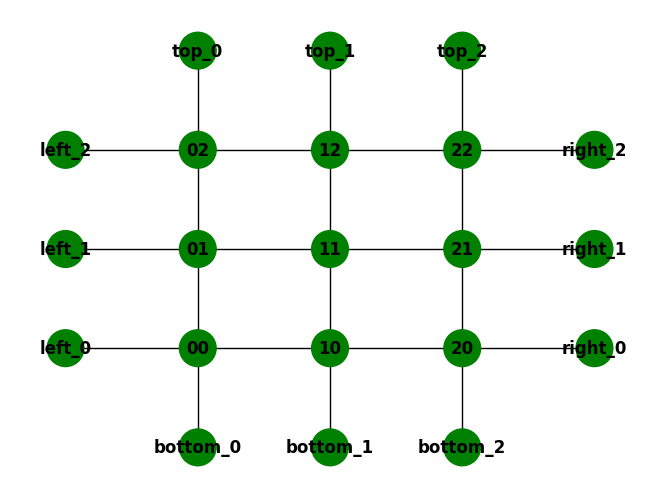

Time taken by plot_network: 1.73 seconds
Time taken by reserve_path: 0.0 seconds
Time taken by Communication.__init__: 0.0 seconds
Time taken by is_complete: 0.0 seconds
Time taken by H gate application: 0.01 seconds
Time taken by dephasing on q0: 0.01 seconds
Time taken by dephasing on q1: 0.0 seconds
Total time taken by entanglement_generation: 0.01 seconds
Comm 0: Entanglement generated between qubits 0 and 1
Time taken by H gate application: 0.0 seconds
Time taken by dephasing on q0: 0.0 seconds
Time taken by dephasing on q1: 0.0 seconds
Total time taken by entanglement_generation: 0.01 seconds
Comm 0: Entanglement generated between qubits 2 and 3
Comm 0: Photon lost, link not generated between qubits 4 and 5
Comm 0: Photon lost, link not generated between qubits 6 and 7
Time taken by attempt_entanglement: 0.03 seconds
Time taken by Bell measurement: 0.13 seconds
Total time taken by entanglement_swapping: 0.13 seconds
BSM performed on qubits 1 and 2
Time taken by perform_entangleme

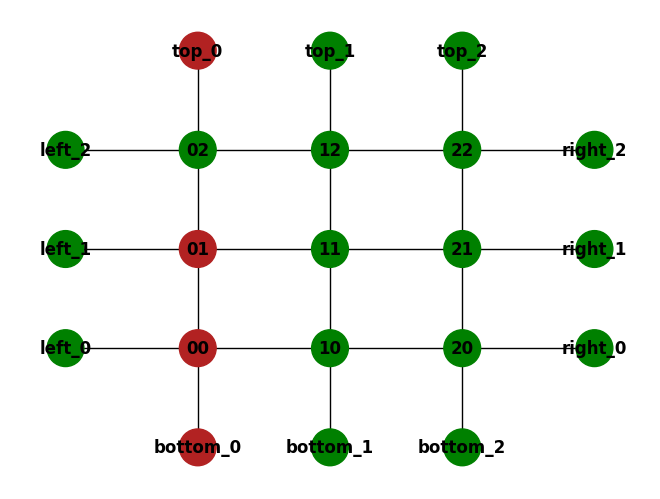

Time taken by plot_network: 0.66 seconds
Time taken by is_complete: 0.0 seconds
Time taken by H gate application: 0.02 seconds
Time taken by dephasing on q0: 0.01 seconds
Time taken by dephasing on q1: 0.01 seconds
Total time taken by entanglement_generation: 0.04 seconds
Comm 0: Entanglement generated between qubits 4 and 5
Time taken by H gate application: 0.01 seconds
Time taken by dephasing on q0: 0.0 seconds
Time taken by dephasing on q1: 0.0 seconds
Total time taken by entanglement_generation: 0.01 seconds
Comm 0: Entanglement generated between qubits 6 and 7
Time taken by attempt_entanglement: 0.05 seconds
Time taken by Bell measurement: 0.13 seconds
Total time taken by entanglement_swapping: 0.13 seconds
BSM performed on qubits 3 and 4
Time taken by Bell measurement: 0.25 seconds
Total time taken by entanglement_swapping: 0.25 seconds
BSM performed on qubits 5 and 6
Time taken by perform_entanglement_swapping: 0.38 seconds
Com 0: dephasing applied to qubit 0
Com 0: dephasing ap

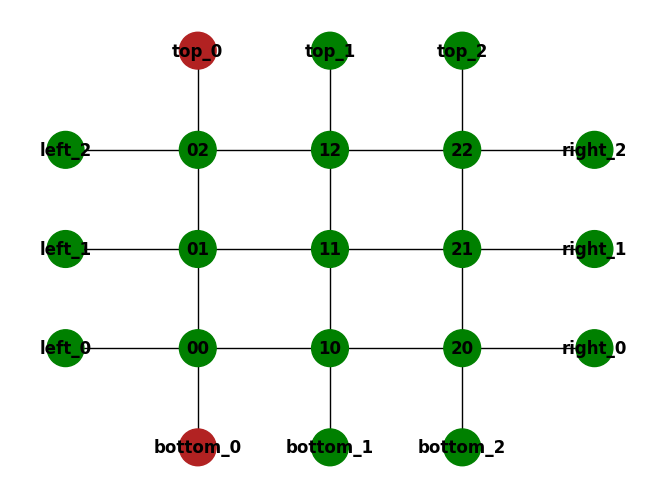

Time taken by plot_network: 0.56 seconds
Time taken by reserve_path: 0.0 seconds
Time taken by Communication.__init__: 0.22 seconds
Time taken by is_complete: 0.0 seconds
Time taken by is_complete: 0.0 seconds
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49900092+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49900092+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 4


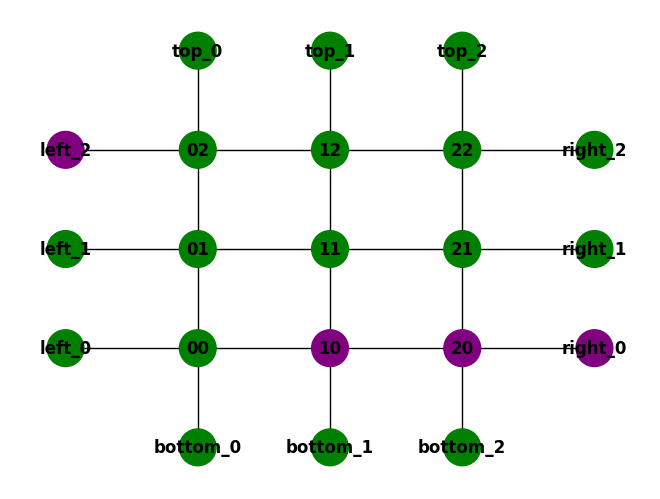

Time taken by plot_network: 1.34 seconds


KeyboardInterrupt: 

In [17]:
fidelities_dict = {}


T_dp_list = [ 0.1]
d_list = [5e3]
for d in d_list:
    for T_dp in T_dp_list:
        # Main execution
        grid_size = 3
        random.seed(2)
        fidelities = []
        simulation_time = 10

        # Create the simulation environment
        env = simpy.Environment()

        # Create and connect the grid network
        grid = CustomGrid(grid_size, env)

        # Generate different shades of red for communications
        shades_of_red = ["#B22222", "#800080", "#B03060", "#DAA520", "#BC8F8F"]

        # List to store communication attempts
        communication_queue = []

        # Start the communication manager
        env.process(communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d))

        # Generate communication attempts from edge nodes
        env.process(generate_communications(env, grid, communication_queue))

        # Start the plot manager
        env.process(plot_manager(env, grid, shades_of_red))

        # Run the simulation
        env.run(until=simulation_time)  # Run the simulation for 15 time steps

        rate = len(fidelities)/simulation_time
        avg_fidelity = np.mean(fidelities)

        fidelities_dict[f"T_dp={T_dp}, d={d}"] = {
            "T_dp": T_dp,
            "d": d,
            "rate": rate,
            "avg_fidelity": avg_fidelity
        }


In [ ]:
np.linspace(1, 30000, 8)

array([1.00000000e+00, 4.28657143e+03, 8.57214286e+03, 1.28577143e+04,
       1.71432857e+04, 2.14288571e+04, 2.57144286e+04, 3.00000000e+04])

In [ ]:
fidelities_dict = {}


T_dp_list = np.logspace(start=-8, stop=-3, num=12)
d_list = np.linspace(1, 30000, 8)
for d in d_list:
    for T_dp in T_dp_list:
        # Main execution
        grid_size = 3
        random.seed(2)
        fidelities = []
        simulation_time = 10

        # Create the simulation environment
        env = simpy.Environment()

        # Create and connect the grid network
        grid = CustomGrid(grid_size, env)

        # Generate different shades of red for communications
        shades_of_red = ["#B22222", "#800080", "#B03060", "#DAA520", "#BC8F8F"]

        # List to store communication attempts
        communication_queue = []

        # Start the communication manager
        env.process(communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d))

        # Generate communication attempts from edge nodes
        env.process(generate_communications(env, grid, communication_queue))

        # Start the plot manager
        #env.process(plot_manager(env, grid, shades_of_red))

        # Run the simulation
        env.run(until=simulation_time)  # Run the simulation for 15 time steps

        if fidelities:
            rate = len(fidelities)/(simulation_time * 2 * d / c)
            avg_fidelity = np.mean(fidelities)
        else:
            rate, avg_fidelity = 0, 0

        fidelities_dict[f"T_dp={T_dp}, d={d}"] = {
            "T_dp": T_dp,
            "d": d,
            "rate": rate,
            "avg_fidelity": avg_fidelity
        }


Streaming output truncated to the last 5000 lines.
Com 2: dephasing applied to qubit 7
Comm 3: Entanglement generated between qubits 0 and 1
Comm 3: Entanglement generated between qubits 2 and 3
Comm 3: Entanglement generated between qubits 4 and 5
Comm 3: Photon lost, link not generated between qubits 6 and 7
BSM performed on qubits 1 and 2
BSM performed on qubits 3 and 4
Com 3: dephasing applied to qubit 0
Com 3: dephasing applied to qubit 5
Comm 2: Entanglement generated between qubits 2 and 3
BSM performed on qubits 1 and 2
BSM performed on qubits 3 and 4
Com 2: dephasing applied to qubit 0
Com 2: dephasing applied to qubit 7
Comm 4: Entanglement generated between qubits 0 and 1
Comm 4: Photon lost, link not generated between qubits 2 and 3
Comm 4: Entanglement generated between qubits 4 and 5
Comm 4: Entanglement generated between qubits 6 and 7
BSM performed on qubits 5 and 6
Com 4: dephasing applied to qubit 0
Com 4: dephasing applied to qubit 1
Com 4: dephasing applied to qubit

In [5]:
class CustomGrid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env
        self.network = self.create_custom_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_custom_grid_network(self):
        """
        Create a grid-based network graph with additional nodes connected to the edge nodes.
        """
        network = nx.Graph()

        # Create the standard grid network
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)

        # Add edges for the standard grid connections
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)

        # Add external nodes for each edge node and connect them
        for y in range(self.grid_size):
            network.add_node(f"left_{y}")
            network.add_edge(f"0{y}", f"left_{y}")
            network.add_node(f"right_{y}")
            network.add_edge(f"{self.grid_size - 1}{y}", f"right_{y}")

        for x in range(self.grid_size):
            network.add_node(f"bottom_{x}")
            network.add_edge(f"{x}0", f"bottom_{x}")
            network.add_node(f"top_{x}")
            network.add_edge(f"{x}{self.grid_size - 1}", f"top_{x}")

        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with node colors based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}

        for y in range(self.grid_size):
            pos[f"left_{y}"] = (-1, y)
            pos[f"right_{y}"] = (self.grid_size, y)
        for x in range(self.grid_size):
            pos[f"bottom_{x}"] = (x, -1)
            pos[f"top_{x}"] = (x, self.grid_size)

        colors = ['green' if self.node_statuses[node] == 'free' else shades_of_red[self.node_statuses[node]] for node in self.network.nodes()]

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free'.
        """
        self.node_statuses[node] = 'free'
        #print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, color_index):
        """
        Reserve the path by marking all nodes as 'busy' with the communication color index.
        """
        for node in path:
            self.node_statuses[node] = color_index

class Communication:
    def __init__(self, communication_id, path, grid, color_index):
        self.communication_id = communication_id
        self.path = path
        self.grid = grid
        self.color_index = color_index
        self.grid.reserve_path(self.path, self.color_index)
        self.num_nodes = len(path)
        self.num_qubits = 2 * self.num_nodes - 2
        self.rho = initial_rho(self.num_qubits)
        self.qubit_status = ["not ready"] * self.num_qubits  # Initialize all qubits as "not ready"

    def attempt_entanglement(self, T_dp, d):
        """
        Attempt to establish entanglement between all adjacent nodes in the path.
        """
        n_channel = np.exp(-d / L_att)

        for i in range(self.num_nodes - 1): # all but last node we attempt to generate entanglement
            first_qubit = 2 * i

            # try generate entanglement if it hasnt already been entangled
            if self.qubit_status[first_qubit] == "not ready":
                if random.uniform(0, 1) < n_channel:
                    # Successful entanglement generation
                    self.rho = entanglement_generation(self, rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits, T_dp=T_dp, d=d)
                    print(f"Comm {self.communication_id}: Entanglement generated between qubits {first_qubit} and {first_qubit + 1}")
                    self.qubit_status[first_qubit] = "ready"
                    self.qubit_status[first_qubit + 1] = "ready"

                else:
                    # Failed entanglement generation
                    print(f"Comm {self.communication_id}: Photon lost, link not generated between qubits {first_qubit} and {first_qubit+1}")




    def perform_entanglement_swapping(self):
        """
        Perform BSM on adjacent qubits that are marked as "ready".
        """
        for i in range(1, self.num_nodes - 1):
            first_qubit = 2 * i - 1

            if self.qubit_status[first_qubit] == "ready" and self.qubit_status[first_qubit + 1] == "ready":
                # Perform BSM if both adjacent qubits are "ready"
                self.rho = entanglement_swapping(rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits)
                print(f"BSM performed on qubits {first_qubit} and {first_qubit + 1}")
                self.qubit_status[first_qubit] = "swapped"
                self.qubit_status[first_qubit + 1] = "swapped"
                self.grid.free_node(self.path[i])

    def dephase_ready_qubits(self, T_dp, d):
          for qubit_index, qubit_stat in enumerate(self.qubit_status):
              if qubit_stat == "ready":
                  left_padding = qubit_index
                  right_padding = (self.num_qubits - 1) - qubit_index
                  self.rho = dephasing_channel(self.rho, 1, T_dp, d, left_padding, right_padding, self.num_qubits)
                  print(f"Com {self.communication_id}: dephasing applied to qubit {qubit_index}")



    def advance(self, T_dp, d):
        """
        Continue the process of entanglement generation and swapping until no more qubits are marked as "ready".
        """
        self.attempt_entanglement(T_dp, d)
        self.perform_entanglement_swapping()
        self.dephase_ready_qubits(T_dp, d)


    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return all(status == "swapped" for status in self.qubit_status[1:-1])

    def complete_communication(self, env):
        """
        Free all nodes in the path after the communication is complete.
        """
        final_state = self.rho.ptrace([0, self.num_qubits - 1])
        print(f"FINAL BELL STATE: {final_state.full()}")

        # Free all nodes in the path
        for node in self.path:
            self.grid.free_node(node)

        yield env.timeout(0)  # Ensure this method behaves like a generator

        fidelity = np.real(phi_plus_ket.dag() * final_state * phi_plus_ket)
        global fidelities
        fidelities.append(fidelity)

def communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    color_index = current_id % len(shades_of_red)
                    communication = Communication(current_id, path, grid, color_index)
                    env.process(move_packet(env, communication, T_dp, d))
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)

        yield env.timeout(1)


def move_packet(env, communication, T_dp, d):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    """
    while not communication.is_complete():
        communication.advance(T_dp, d)
        yield env.timeout(1)  # Introduce a 1-time step delay between rounds

    yield env.process(communication.complete_communication(env))



def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    """
    while True:
        yield env.timeout(1)
        print(f"TIME: {env.now}")
        grid.plot_network(shades_of_red)

def generate_communications(env, grid, communication_queue):
    """
    Generate communication attempts between edge nodes according to the rules.
    """
    top_nodes = [f"top_{x}" for x in range(grid.grid_size)]
    bottom_nodes = [f"bottom_{x}" for x in range(grid.grid_size)]
    left_nodes = [f"left_{y}" for y in range(grid.grid_size)]
    right_nodes = [f"right_{y}" for y in range(grid.grid_size)]

    communication_id = 0

    while True:
        source_group = random.choice(['top', 'bottom', 'left', 'right'])

        if source_group == 'top':
            source_node = random.choice(top_nodes)
            target_node = random.choice(bottom_nodes)
        elif source_group == 'bottom':
            source_node = random.choice(bottom_nodes)
            target_node = random.choice(top_nodes)
        elif source_group == 'left':
            source_node = random.choice(left_nodes)
            target_node = random.choice(right_nodes)
        elif source_group == 'right':
            source_node = random.choice(right_nodes)
            target_node = random.choice(left_nodes)

        # Generate the shortest path between source and target
        all_paths = list(nx.all_shortest_paths(grid.network, source=source_node, target=target_node))

        path_reserved = False

        for path in all_paths:
            if grid.is_path_free(path):
                communication_queue.append((env.now, source_node, target_node, communication_id))
                path_reserved = True
                break

        if path_reserved:
            communication_id += 1

        yield env.timeout(1)  # Wait for the next time step

In [14]:
for key, value in fidelities_dict.items():
    print(f"Entry: {key}")
    print(f"  Dephasing Time (T_dp): {value['T_dp']}")
    print(f"  Distance (d): {value['d']}")
    print(f"  Rate: {value['rate']}")
    print(f"  Average Fidelity: {value['avg_fidelity']}")
    print()  # Add a blank line for readability between entries


Entry: T_dp=1e-08, d=1.0
  Dephasing Time (T_dp): 1e-08
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.5676676369782315

Entry: T_dp=2.848035868435799e-08, d=1.0
  Dephasing Time (T_dp): 2.848035868435799e-08
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.7477375023911413

Entry: T_dp=8.111308307896871e-08, d=1.0
  Dephasing Time (T_dp): 8.111308307896871e-08
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.8907385796300351

Entry: T_dp=2.3101297000831583e-07, d=1.0
  Dephasing Time (T_dp): 2.3101297000831583e-07
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.9585332782828356

Entry: T_dp=6.579332246575682e-07, d=1.0
  Dephasing Time (T_dp): 6.579332246575682e-07
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.9850295785218574

Entry: T_dp=1.873817422860383e-06, d=1.0
  Dephasing Time (T_dp): 1.873817422860383e-06
  Distance (d): 1.0
  Rate: 70000000.0
  Average Fidelity: 0.9946916798888301

Entry: T_dp=5.33669923120630

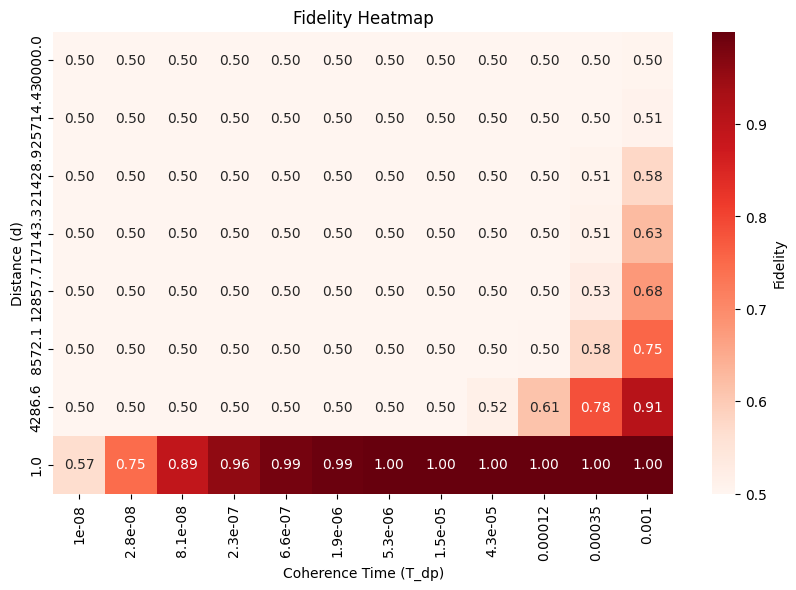

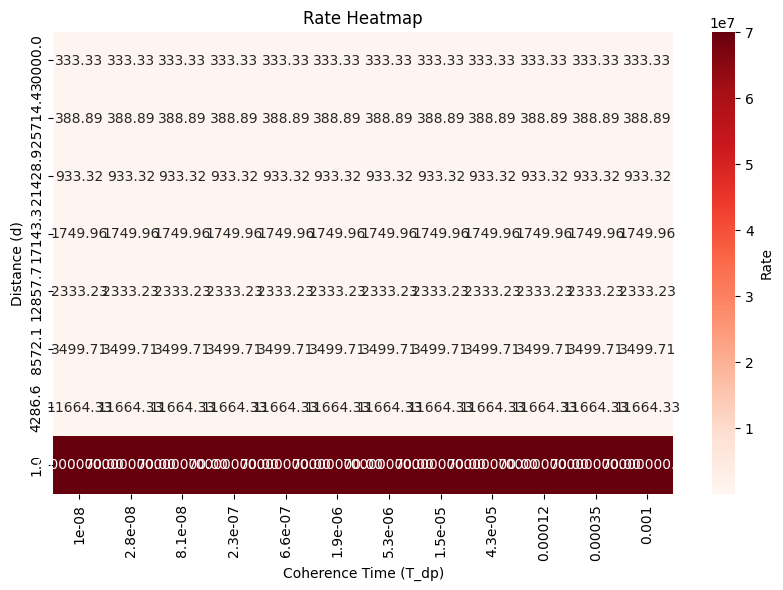

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example data for demonstration purposes
# Extract distances, coherence times, rates, and fidelities from the dictionary
distances = sorted(set(value['d'] for value in fidelities_dict.values()))
coherence_times = sorted(set(value['T_dp'] for value in fidelities_dict.values()))

# Create matrices for fidelity and rate
fidelity_matrix = np.zeros((len(distances), len(coherence_times)))
rate_matrix = np.zeros((len(distances), len(coherence_times)))

for key, value in fidelities_dict.items():
    d_index = distances.index(value['d'])
    T_dp_index = coherence_times.index(value['T_dp'])
    fidelity_matrix[d_index, T_dp_index] = value['avg_fidelity']
    rate_matrix[d_index, T_dp_index] = value['rate']

# Convert to DataFrames for easier plotting
fidelity_df = pd.DataFrame(fidelity_matrix, index=distances, columns=coherence_times)
rate_df = pd.DataFrame(rate_matrix, index=distances, columns=coherence_times)

# Convert x_labels to 3 decimal places and y_labels to 1 decimal place
fidelity_df.columns = [f'{x:.2g}' for x in fidelity_df.columns]
fidelity_df.index = [f'{y:.1f}' for y in fidelity_df.index]

rate_df.columns = [f'{x:.2g}' for x in rate_df.columns]
rate_df.index = [f'{y:.1f}' for y in rate_df.index]

sns.cubehelix_palette(as_cmap=True)

# Plot the Fidelity Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fidelity_df, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Fidelity'}, yticklabels=True)
plt.title("Fidelity Heatmap")
plt.xlabel("Coherence Time (T_dp)")
plt.ylabel("Distance (d)")
plt.gca().invert_yaxis()  # Invert the y-axis so that smallest distances are at the bottom
plt.show()

# Plot the Rate Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rate_df, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Rate'}, yticklabels=True)
plt.title("Rate Heatmap")
plt.xlabel("Coherence Time (T_dp)")
plt.ylabel("Distance (d)")
plt.gca().invert_yaxis()  # Invert the y-axis so that smallest distances are at the bottom
plt.show()



# Testing out partial tracing

In [ ]:

def entanglement_generation(rho: Qobj, target_qubits: list, num_qubits: int, n: int, P_link: float, T_p: float, eta_eff: float, F_initial=0.7):
    """
    NOTE: q1 must be greater than q0
    """
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    rho = perfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, F_initial, num_qubits)

    # dephasing on q0
    rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)

    # dephasing on q1
    rho = dephasing_channel(rho=rho, t=d / c, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)


    if q0 > 1:
        # dephasing on left of q0
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left - 1, right_padding=num_qubits_right + 2, num_qubits=num_qubits)

        # dephasing on first qubit
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=0, right_padding=num_qubits - 1, num_qubits=num_qubits)


    #rho = dark_counts(rho_initial=rho, target=q1, P_link=P_link, num_qubits=num_qubits)

    return rho

def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int, lambda_BSM=1):
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    bell_measure_op = pad_op(phi_plus_rho, left_padding = num_qubits_left, right_padding = num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()

    # adding bell state measurement error
    #rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())
    return rho



num_qubits = 8
rho = initial_rho(num_qubits)
rho = entanglement_generation(rho=rho, target_qubits=[0,1], num_qubits=num_qubits)
rho = entanglement_generation(rho = rho, target_qubits=[2,3], num_qubits=num_qubits)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL TRACE B4')
print("Q0Q1\n", rho.ptrace([0,1]).full())
print("Q2Q3\n", rho.ptrace([2,3]).full())
rho = entanglement_swapping(rho = rho , target_qubits = [1,2], num_qubits=num_qubits)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL AFTER')
print("Q0Q3\n", rho.ptrace([0,3]).full())



In [ ]:
BSM_qubits = [i for i in range(10)]
length = len(BSM_qubits)
measured_qubits = []
j = 0
while j < length-2: # bell state measurements up until last qubit
  print (j)
  removed_element = BSM_qubits.pop(j)
  measured_qubits.append(removed_element)
  j += 2


In [ ]:
BSM_qubits = [i for i in range(10)]
measured_qubits = []

while BSM_qubits:
    # Measure qubits at even indices in the current list
    for j in range(0, len(BSM_qubits), 2):
        measured_qubits.append(BSM_qubits[j])

    # Remove the measured qubits from BSM_qubits
    BSM_qubits = [q for q in BSM_qubits if q not in measured_qubits]

    print("Measured qubits:", measured_qubits)
    print("Remaining BSM_qubits:", BSM_qubits)

print("Final Measured qubits:", measured_qubits)
